# Set up

To run in Google Colab, we need to import the git repository files.

In [1]:
!git clone https://github.com/kubekj/SSM_EHR_Classification.git

Cloning into 'SSM_EHR_Classification'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 597 (delta 160), reused 137 (delta 124), pack-reused 408 (from 3)
Receiving objects: 100% (597/597), 187.71 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (286/286), done.


In [8]:
%cd /content/SSM_EHR_Classification

/content/SSM_EHR_Classification


In [9]:
!ls

deliverable.ipynb		       models					README.md
grid_search_intermediate_results.json  notebooks				requirements.txt
hpc_scripts			       P12data					scripts
model_outputs			       random_search_intermediate_results.json	train.py


We extract the data files.

In [10]:
import tarfile
import os


# Iterate through all files in the directory
for filename in os.listdir():
    if filename.endswith(".tar.gz"):
        # Construct the full path to the .tar.gz file
        filepath = os.path.join(os.getcwd(), filename)

        try:
            # Open the tar.gz file
            with tarfile.open(filepath, "r:gz") as tar:
                # Extract all contents of the tar.gz file to the current directory
                tar.extractall()
                print(f"Extracted: {filename}")

        except tarfile.ReadError:
            print(f"Error reading or extracting {filename}. Skipping...")

        except Exception as e:
            print(f"An unexpected error occurred while processing {filename}: {e}")

**** *Disclaimer* ****

The process described in this notebook replicates the method outlined in the report, using a combination of random search and grid search for hyperparameter tuning. However, it is important to note the following:

- Differences in Computational Resources: The original experiments were conducted on the DTU's High-Performance Computing (HPC) cluster with extensive computational resources. This allowed for large-scale experiments with a broader search space and more iterations.

- Simplification for Demonstration: This notebook is designed to be executable by anyone on a local machine or modest computational resources. As such:

  - The data size and number of iterations for random and grid searches have been significantly reduced.
  - The results produced by this notebook will differ from the report because the scale of experimentation is smaller.
- Process Integrity: Despite these differences, the overall methodology remains consistent. The workflow, including random search followed by grid search on the refined parameter space, matches the approach used in the report.

By making these adjustments, this notebook ensures accessibility while maintaining the integrity of the described hyperparameter optimization process.

*To make sure that the notebooks stays as readable as possible, we won't implement code that is already implemented in other files.*

**ATTENTION: Make sure to have the data properly extracted!!!!**
It should be:
```
P12data
|___split1
|___split2
|___split3
|___split4
|___split5
```

# Reduce data

We're going to keep 5% of the data.

In [11]:
import os
import numpy as np

def process_splits(base_dir, file_prefixes=["test_physionet2012", "train_physionet2012", "validation_physionet2012"]):
    """
    Iterates over directories named split1, split2, ..., processes the three files inside
    to keep only 5% of the rows, and replaces the original files.

    Args:
        base_dir (str): The base directory containing split directories.
        file_prefixes (list): List of file prefixes to process within each split directory.
    """
    # Iterate over directories in the base directory
    for split_dir in os.listdir(base_dir):
        split_path = os.path.join(base_dir, split_dir)
        if os.path.isdir(split_path) and split_dir.startswith("split"):
            print(f"Processing directory: {split_dir}")

            # Process each file in the split directory
            for prefix in file_prefixes:
                file_name = f"{prefix}_{split_dir[-1]}.npy"
                file_path = os.path.join(split_path, file_name)

                if os.path.exists(file_path):
                    print(f"Processing file: {file_path}")
                    try:
                        # Load data from .npy file
                        data = np.load(file_path, allow_pickle=True)

                        # Randomly select 5% of rows
                        sampled_data = data[np.random.choice(len(data), int(0.05 * len(data)), replace=False)]

                        # Save the sampled data back to the same file
                        np.save(file_path, sampled_data)
                        print(f"Replaced file with 5% sampled data: {file_path}")
                    except Exception as e:
                        print(f"Error processing file {file_path}: {e}")
                else:
                    print(f"File not found: {file_path}")

# Example usage
base_directory = "P12data"  # Replace with the path to the directory containing the split folders
process_splits(base_directory)


Processing directory: split_5
Processing file: P12data/split_5/test_physionet2012_5.npy
Replaced file with 5% sampled data: P12data/split_5/test_physionet2012_5.npy
Processing file: P12data/split_5/train_physionet2012_5.npy
Replaced file with 5% sampled data: P12data/split_5/train_physionet2012_5.npy
Processing file: P12data/split_5/validation_physionet2012_5.npy
Replaced file with 5% sampled data: P12data/split_5/validation_physionet2012_5.npy
Processing directory: split_2
Processing file: P12data/split_2/test_physionet2012_2.npy
Replaced file with 5% sampled data: P12data/split_2/test_physionet2012_2.npy
Processing file: P12data/split_2/train_physionet2012_2.npy
Replaced file with 5% sampled data: P12data/split_2/train_physionet2012_2.npy
Processing file: P12data/split_2/validation_physionet2012_2.npy
Replaced file with 5% sampled data: P12data/split_2/validation_physionet2012_2.npy
Processing directory: split_4
Processing file: P12data/split_4/test_physionet2012_4.npy
Replaced file 

# Random search

In [12]:
import random
import json
import torch
from scripts.random_search import random_search
from models.dssm import DSSM

param_grid = {
    # Model parameters
    'hidden_size': [32, 64, 128, 256],  # Capacity of the model
    'num_layers': [1, 2, 3],  # Depth of LSTM
    'dropout_rate': [0.1, 0.2, 0.3, 0.4],   # Regularization strength

    # Training parameters
    'learning_rate': [0.01, 0.001, 0.0001],  # Regularization strength
    'batch_size': [16, 32, 64],  # Batch sizes
    'class_weights': [
         [1.0, 7.143], [1.0, 8.5],
        [1.0, 6.0], [1.0, 5.0]
    ],
    'bidirectional': [True, False],  # Whether to use a bidirectional LSTM
}

best_params_random_search, best_metrics_random_search, all_results_random_search = random_search(n_iter = 50, param_grid = param_grid, results_path_str='model_outputs/dssm_output/random_search_results.json')

Se han truncado las últimas 5000 líneas del flujo de salida.
Split 1, Epoch 46/100
Train Loss: 0.6274, Val Loss: 0.6363
Val AUROC: 0.7304, Val AUPRC: 0.3585

Split 1, Epoch 47/100
Train Loss: 0.6270, Val Loss: 0.6351
Val AUROC: 0.7304, Val AUPRC: 0.3620

Split 1, Epoch 48/100
Train Loss: 0.6248, Val Loss: 0.6342
Val AUROC: 0.7255, Val AUPRC: 0.3527

Split 1, Epoch 49/100
Train Loss: 0.6165, Val Loss: 0.6333
Val AUROC: 0.7255, Val AUPRC: 0.3525

Split 1, Epoch 50/100
Train Loss: 0.6131, Val Loss: 0.6326
Val AUROC: 0.7206, Val AUPRC: 0.3445

Split 1, Epoch 51/100
Train Loss: 0.6066, Val Loss: 0.6323
Val AUROC: 0.7083, Val AUPRC: 0.3351

Split 1, Epoch 52/100
Train Loss: 0.5842, Val Loss: 0.6326
Val AUROC: 0.6912, Val AUPRC: 0.3243
EarlyStopping counter: 1 out of 10

Split 1, Epoch 53/100
Train Loss: 0.5863, Val Loss: 0.6337
Val AUROC: 0.6887, Val AUPRC: 0.3220
EarlyStopping counter: 2 out of 10

Split 1, Epoch 54/100
Train Loss: 0.5824, Val Loss: 0.6357
Val AUROC: 0.6912, Val AUPRC: 0.32

In [13]:
import pandas as pd
def show_results(data):
    # Transform the data into a pandas DataFrame
    rows = []
    for entry in data:
        combined = {**entry["params"], **entry["metrics"]}
        # Convert class_weights to a tuple to make it hashable
        combined["class_weights"] = tuple(combined["class_weights"])
        rows.append(combined)

    df = pd.DataFrame(rows)

    # Display the DataFrame
    return df

df = show_results(all_results_random_search)
df.sort_values("combined_score", ascending=False)

,hidden_size,num_layers,dropout_rate,learning_rate,batch_size,class_weights,bidirectional,loss,accuracy,auprc,auroc,mean_auroc,mean_auprc,mean_accuracy,combined_score
29,64,1,0.3,0.0010,16,"(1.0, 5.0)",True,0.455573,0.830508,0.319963,0.862963,0.862963,0.319963,0.830508,0.636027
35,256,1,0.3,0.0010,64,"(1.0, 5.0)",False,0.530237,0.762712,0.380013,0.818519,0.818519,0.380013,0.762712,0.626374
36,128,2,0.1,0.0001,16,"(1.0, 5.0)",False,0.437962,0.762712,0.343743,0.866667,0.866667,0.343743,0.762712,0.626311
14,32,2,0.1,0.0010,16,"(1.0, 5.0)",True,0.491869,0.813559,0.310000,0.848148,0.848148,0.310000,0.813559,0.622512
10,64,1,0.3,0.0100,64,"(1.0, 8.5)",False,0.595271,0.796610,0.305894,0.840741,0.840741,0.305894,0.796610,0.613563
41,128,1,0.3,0.0001,16,"(1.0, 6.0)",True,0.482292,0.796610,0.291212,0.851852,0.851852,0.291212,0.796610,0.611023
27,256,3,0.1,0.0001,16,"(1.0, 5.0)",True,0.459383,0.779661,0.308747,0.844444,0.844444,0.308747,0.779661,0.610730
38,64,3,0.1,0.0001,32,"(1.0, 7.143)",True,0.496381,0.728814,0.326812,0.859259,0.859259,0.326812,0.728814,0.607146
3,128,1,0.1,0.0001,32,"(1.0, 6.0)",True,0.480602,0.762712,0.295868,0.851852,0.851852,0.295868,0.762712,0.602716
39,64,1,0.3,0.0001,32,"(1.0, 7.143)",True,0.527217,0.745763,0.312105,0.837037,0.837037,0.312105,0.745763,0.599682


# Grid search

Now we keep the hyperparameter values from the top 5 best hyperparameter combinations and try every combination between them. In this case, we make sure that not more than 2 values for each hyperparameter is added (prioritizing the ones with the best metrics), so the grid search space doesn't explode.

*Due to high runtimes, we're going to slash the number of possible combinations by half by eliminating the option `bidirectional: false` because we already know that the best result is with `bidirectional: false` from the testing with every parameter value.*

In [14]:
# Step 1: Sort by AUROC to get the top 5 results
sorted_data = sorted(all_results_random_search, key=lambda x: x['metrics']['combined_score'], reverse=True)
top_5 = sorted_data[:5]
# Step 2: Collect unique values for each hyperparameter in the top 5 results
unique_values = {
    "hidden_size": set(),
    "num_layers": set(),
    "dropout_rate": set(),
    "learning_rate": set(),
    "batch_size": set(),
    "class_weights": set(),
    "bidirectional": set()
}
for entry in top_5:
    params = entry["params"]
    for key in unique_values.keys():
        if len(unique_values[key]) < 2:
            unique_values[key].add(tuple(params[key]) if isinstance(params[key], list) else params[key])

# Convert sets to lists for better readability
unique_values = {key: list(values) for key, values in unique_values.items()}

# Bidirectional only true
unique_values["bidirectional"] = [True]

# Display the result
unique_values

{'hidden_size': [64, 256],
 'num_layers': [1, 2],
 'dropout_rate': [0.3, 0.1],
 'learning_rate': [0.0001, 0.001],
 'batch_size': [16, 64],
 'class_weights': [(1.0, 8.5), (1.0, 5.0)],
 'bidirectional': [True]}

In [19]:
import train
from importlib import reload
reload(train)
from train import grid_search

best_params_grid_search, best_metrics_grid_search, all_results_grid_search = grid_search(n_epochs = 20,param_grid = unique_values, split_number=[1,2,3])

Streaming output truncated to the last 5000 lines.
Val AUROC: 0.7400, Val AUPRC: 0.3494
EarlyStopping counter: 4 out of 10

Split 2, Epoch 7/20
Train Loss: 0.5189, Val Loss: 0.7796
Val AUROC: 0.7533, Val AUPRC: 0.4650
EarlyStopping counter: 5 out of 10

Split 2, Epoch 8/20
Train Loss: 0.4536, Val Loss: 1.2386
Val AUROC: 0.7378, Val AUPRC: 0.4502
EarlyStopping counter: 6 out of 10

Split 2, Epoch 9/20
Train Loss: 0.5253, Val Loss: 1.1115
Val AUROC: 0.7311, Val AUPRC: 0.4444
EarlyStopping counter: 7 out of 10

Split 2, Epoch 10/20
Train Loss: 0.7047, Val Loss: 0.7638
Val AUROC: 0.7089, Val AUPRC: 0.3864
EarlyStopping counter: 8 out of 10

Split 2, Epoch 11/20
Train Loss: 0.7022, Val Loss: 0.5993
Val AUROC: 0.6978, Val AUPRC: 0.3546
EarlyStopping counter: 9 out of 10

Split 2, Epoch 12/20
Train Loss: 0.7417, Val Loss: 1.0906
Val AUROC: 0.7089, Val AUPRC: 0.3614
EarlyStopping counter: 10 out of 10
Early stopping triggered at epoch 11

Split 2 Test Metrics:
loss: 0.8832
accuracy: 0.8644
aup

In [20]:
print("Results of the grid search:")
df = show_results(all_results_grid_search)
df.sort_values("combined_score", ascending=False)
df.head(20)

Results of the grid search:


,hidden_size,num_layers,dropout_rate,learning_rate,batch_size,class_weights,bidirectional,mean_loss,std_loss,mean_accuracy,std_accuracy,mean_auprc,std_auprc,mean_auroc,std_auroc,combined_score
0,64,1,0.3,0.0001,16,"(1.0, 8.5)",True,0.640532,0.070814,0.723164,0.062403,0.402063,0.100260,0.797405,0.012011,0.616996
1,64,1,0.3,0.0001,16,"(1.0, 5.0)",True,0.606701,0.048368,0.796610,0.036614,0.398431,0.112314,0.785606,0.025331,0.634037
2,64,1,0.3,0.0001,64,"(1.0, 8.5)",True,0.620682,0.023398,0.485876,0.151808,0.348620,0.048554,0.772432,0.038539,0.516940
3,64,1,0.3,0.0001,64,"(1.0, 5.0)",True,0.620801,0.045484,0.768362,0.034827,0.342122,0.086943,0.741239,0.088603,0.589729
4,64,1,0.3,0.0010,16,"(1.0, 8.5)",True,0.879877,0.348267,0.751412,0.007990,0.354864,0.071664,0.779413,0.035316,0.601193
5,64,1,0.3,0.0010,16,"(1.0, 5.0)",True,1.118897,0.526353,0.807910,0.034827,0.378143,0.029274,0.791172,0.058647,0.630982
6,64,1,0.3,0.0010,64,"(1.0, 8.5)",True,0.746350,0.271287,0.706215,0.052393,0.405908,0.113390,0.801806,0.012663,0.614769
7,64,1,0.3,0.0010,64,"(1.0, 5.0)",True,0.662281,0.160959,0.740113,0.007990,0.452134,0.097977,0.820818,0.019616,0.649133
8,64,1,0.1,0.0001,16,"(1.0, 8.5)",True,0.615146,0.068051,0.745763,0.041517,0.376774,0.074391,0.803207,0.021502,0.615401
9,64,1,0.1,0.0001,16,"(1.0, 5.0)",True,0.615026,0.069813,0.757062,0.021139,0.414918,0.053242,0.803903,0.015604,0.634257


# Generate graphs

This is the graph in the report, with the baseline values. Obviously the results for our data are much worse than the baselines, that were trained with the whole dataset. If you wanted to recreate the same results, rerun the notebook without slashing the data and you'd get a similar model comparison heatmap.

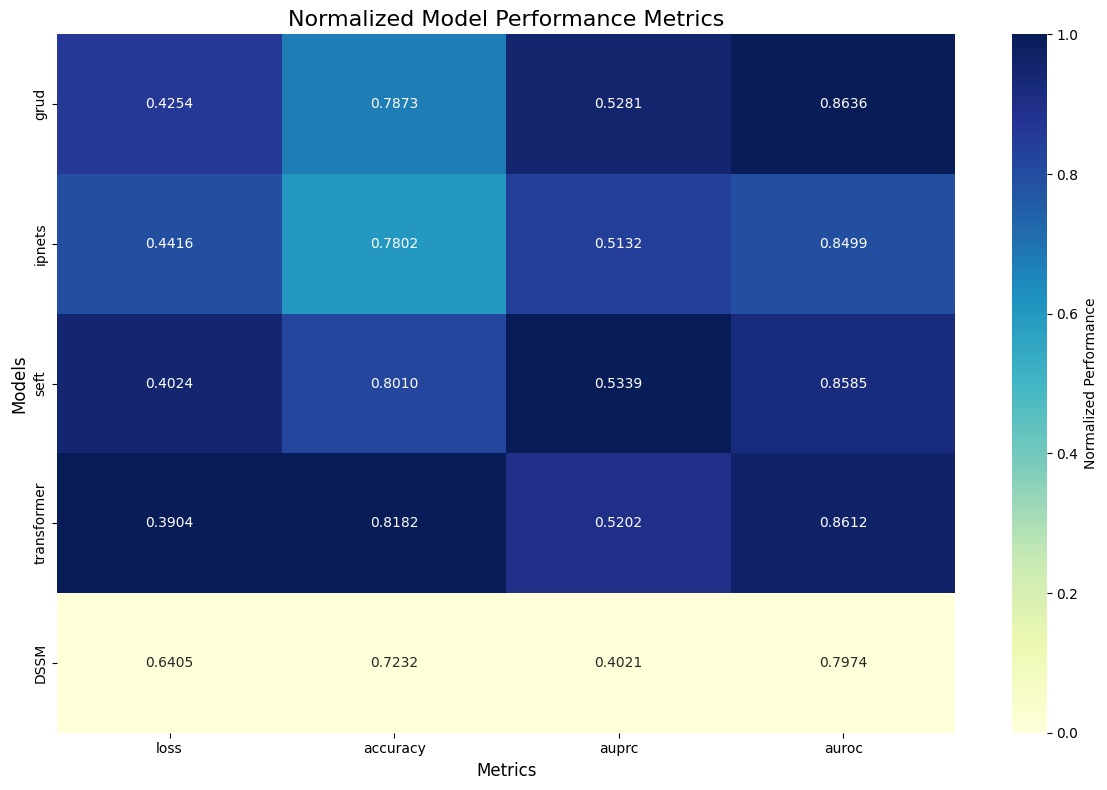

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
# Prepare the data
data = {
    'grud': {
        "loss": 0.4254,
        "accuracy": 0.7873,
        "auprc": 0.5281,
        "auroc": 0.8636
    },
    'ipnets': {
        "loss": 0.4416,
        "accuracy": 0.7802,
        "auprc": 0.5132,
        "auroc": 0.8499
    },
    'seft': {
        "loss": 0.4024,
        "accuracy": 0.801,
        "auprc": 0.5339,
        "auroc": 0.8585
    },
    'transformer': {
        "loss": 0.3904,
        "accuracy": 0.8182,
        "auprc": 0.5202,
        "auroc": 0.8612
    },
    'DSSM': {
       "loss": df['mean_loss'][0],
        "accuracy": df['mean_accuracy'][0],
        "auprc": df['mean_auprc'][0],
        "auroc": df['mean_auroc'][0],
    }
}

# Metrics where lower is better
lower_better = ['loss']

# Create DataFrame
df = pd.DataFrame(data).T

# Normalize the data
def normalize_data(df, lower_better_cols):
    normalized_df = df.copy()
    for col in df.columns:
        if col in lower_better_cols:
            # For lower better metrics, invert and min-max normalize
            col_min = df[col].min()
            col_max = df[col].max()
            normalized_df[col] = 1 - (df[col] - col_min) / (col_max - col_min)
        else:
            # For higher better metrics, do standard min-max normalization
            col_min = df[col].min()
            col_max = df[col].max()
            normalized_df[col] = (df[col] - col_min) / (col_max - col_min)
    return normalized_df

# Normalize data
normalized_df = normalize_data(df, lower_better)

# Set up the plot
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_df, annot=df, cmap='YlGnBu',
            fmt='.4f', cbar_kws={'label': 'Normalized Performance'})

plt.title('Normalized Model Performance Metrics', fontsize=16)
plt.ylabel('Models', fontsize=12)
plt.xlabel('Metrics', fontsize=12)
plt.tight_layout()
plt.show()